In [1]:
using Dates
using PyPlot
using DelimitedFiles
using Statistics
using LinearAlgebra
using Statistics
const plt = PyPlot

PyPlot

# Goal
This notebook creates gridded maps of different plankton abuncances using the `DIVAnd` interpolation too.    
Data are coming from _Continuous Plankton Recorder_ (CPR) and cover the North Sea. 

The steps are:
- reading the data
- preparting the land/sea mask
- setting the analysis parameters
- perform the interpolation

In [2]:
using Pkg
Pkg.develop(path="/home/ctroupin/ULiege/Tools/DIVAnd.jl")

# check with:
Pkg.status()

using DIVAnd
@show pathof(DIVAnd)

      Status `~/.julia/environments/v1.7/Project.toml`
  [336ed68f] CSV v0.9.11
  [8be319e6] Chain v0.4.8
  [8f4d0f93] Conda v1.7.0
  [efc8151c] DIVAnd v2.7.7 `~/ULiege/Tools/DIVAnd.jl`
  [1b7aed40] DIVAndNN v0.1.0 `https://github.com/gher-ulg/DIVAndNN.jl#master`
  [7f46824f] DIVAnd_HFRadar v0.1.0 `https://github.com/gher-ulg/DIVAnd_HFRadar.jl#master`
  [864edb3b] DataStructures v0.18.10
  [b4f34e82] Distances v0.10.6
  [31c24e10] Distributions v0.25.29
  [2fb1d81b] GeoArrays v0.6.0
  [855c05df] GeoMapping v0.0.0 `git@github.com:Alexander-Barth/GeoMapping.jl.git#master`
  [0ef565a4] Geodesy v1.0.1
  [c27321d9] Glob v1.3.0
  [cd3eb016] HTTP v0.9.17
  [7073ff75] IJulia v1.23.2
  [a98d9a8b] Interpolations v0.13.4
  [682c06a0] JSON v0.21.2
  [23992714] MAT v0.10.1
  [e1d29d7a] Missings v1.0.2
  [0db19996] NBInclude v2.3.0
  [85f8d34a] NCDatasets v0.11.7
  [b946abbf] NaNStatistics v0.5.5
  [626c502c] Parquet v0.8.3
  [3725be50] PhysOcean v0.6.5
  [f3e62ec7] PkgCleanup v0.1.0 `https://github

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


"/home/ctroupin/ULiege/Tools/DIVAnd.jl/src/DIVAnd.jl"

## Files and directories
We need to have:
1. the temperature data
2. the CPR observations
3. the bathymetry.

In [3]:
datadir = "../data/"
datadir2 = "../data/WOD/"
figdir = "../figures/multivariateL1/"
resdir = "../results/multivariateL1/"
isdir(resdir) ? @debug("already there") : mkpath(resdir)
isdir(figdir) ? @debug("already there") : mkpath(figdir)

The file `temperature_surface_WOD2.nc` contains all the temperature measurements in the region of interest and for a depth between 5 m and the sea surface.       
It was prepared with the notebook [`read_plot_WOD_data`](read_plot_WOD_data.ipynb).

In [4]:
datafile = joinpath(datadir, "MBA_CPRdata_Emodnet_21Jan22.csv")
isfile(datafile) ? @debug("already downloaded") : download("https://dox.ulg.ac.be/index.php/s/hjWKf1F3C1Pzz1r/download", datafile)
bathfile = joinpath(datadir, "gebco_30sec_16.nc")
isfile(bathfile) ? @debug("already downloaded") : download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download", bathfile)
temperaturefile = joinpath(datadir2, "temperature_surface_WOD2.nc")
isfile(temperaturefile) ? @info("Temperature file already prepared") : download("https://dox.ulg.ac.be/index.php/s/aksXIhEFk41npCb/download", temperaturefile);

┌ Info: Temperature file already prepared
└ @ Main In[4]:6


## Domain, metrics, mask

In [5]:
dom = [-20.5, 11.75, 41.25, 67.]

4-element Vector{Float64}:
 -20.5
  11.75
  41.25
  67.0

In [6]:
Δlon = 0.5
Δlat = 0.5
longrid = dom[1]:Δlon:dom[2]
latgrid = dom[3]:Δlat:dom[4]
@info("Size of the grid: $(length(longrid)) X $(length(latgrid))")

_, (pm, pn), (xi, yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);
@info(size(xi));

┌ Info: Size of the grid: 65 X 52
└ @ Main In[6]:5
┌ Info: (65, 52)
└ @ Main In[6]:8


### Mask

In [7]:
_, _, mask = DIVAnd.load_mask(bathfile, true, longrid, latgrid, 0.0);

# - Resolution = 0.5°
maskindex = findall((xi .>= 0.) .& (yi .<= 47.))
mask[maskindex] .= 0.;

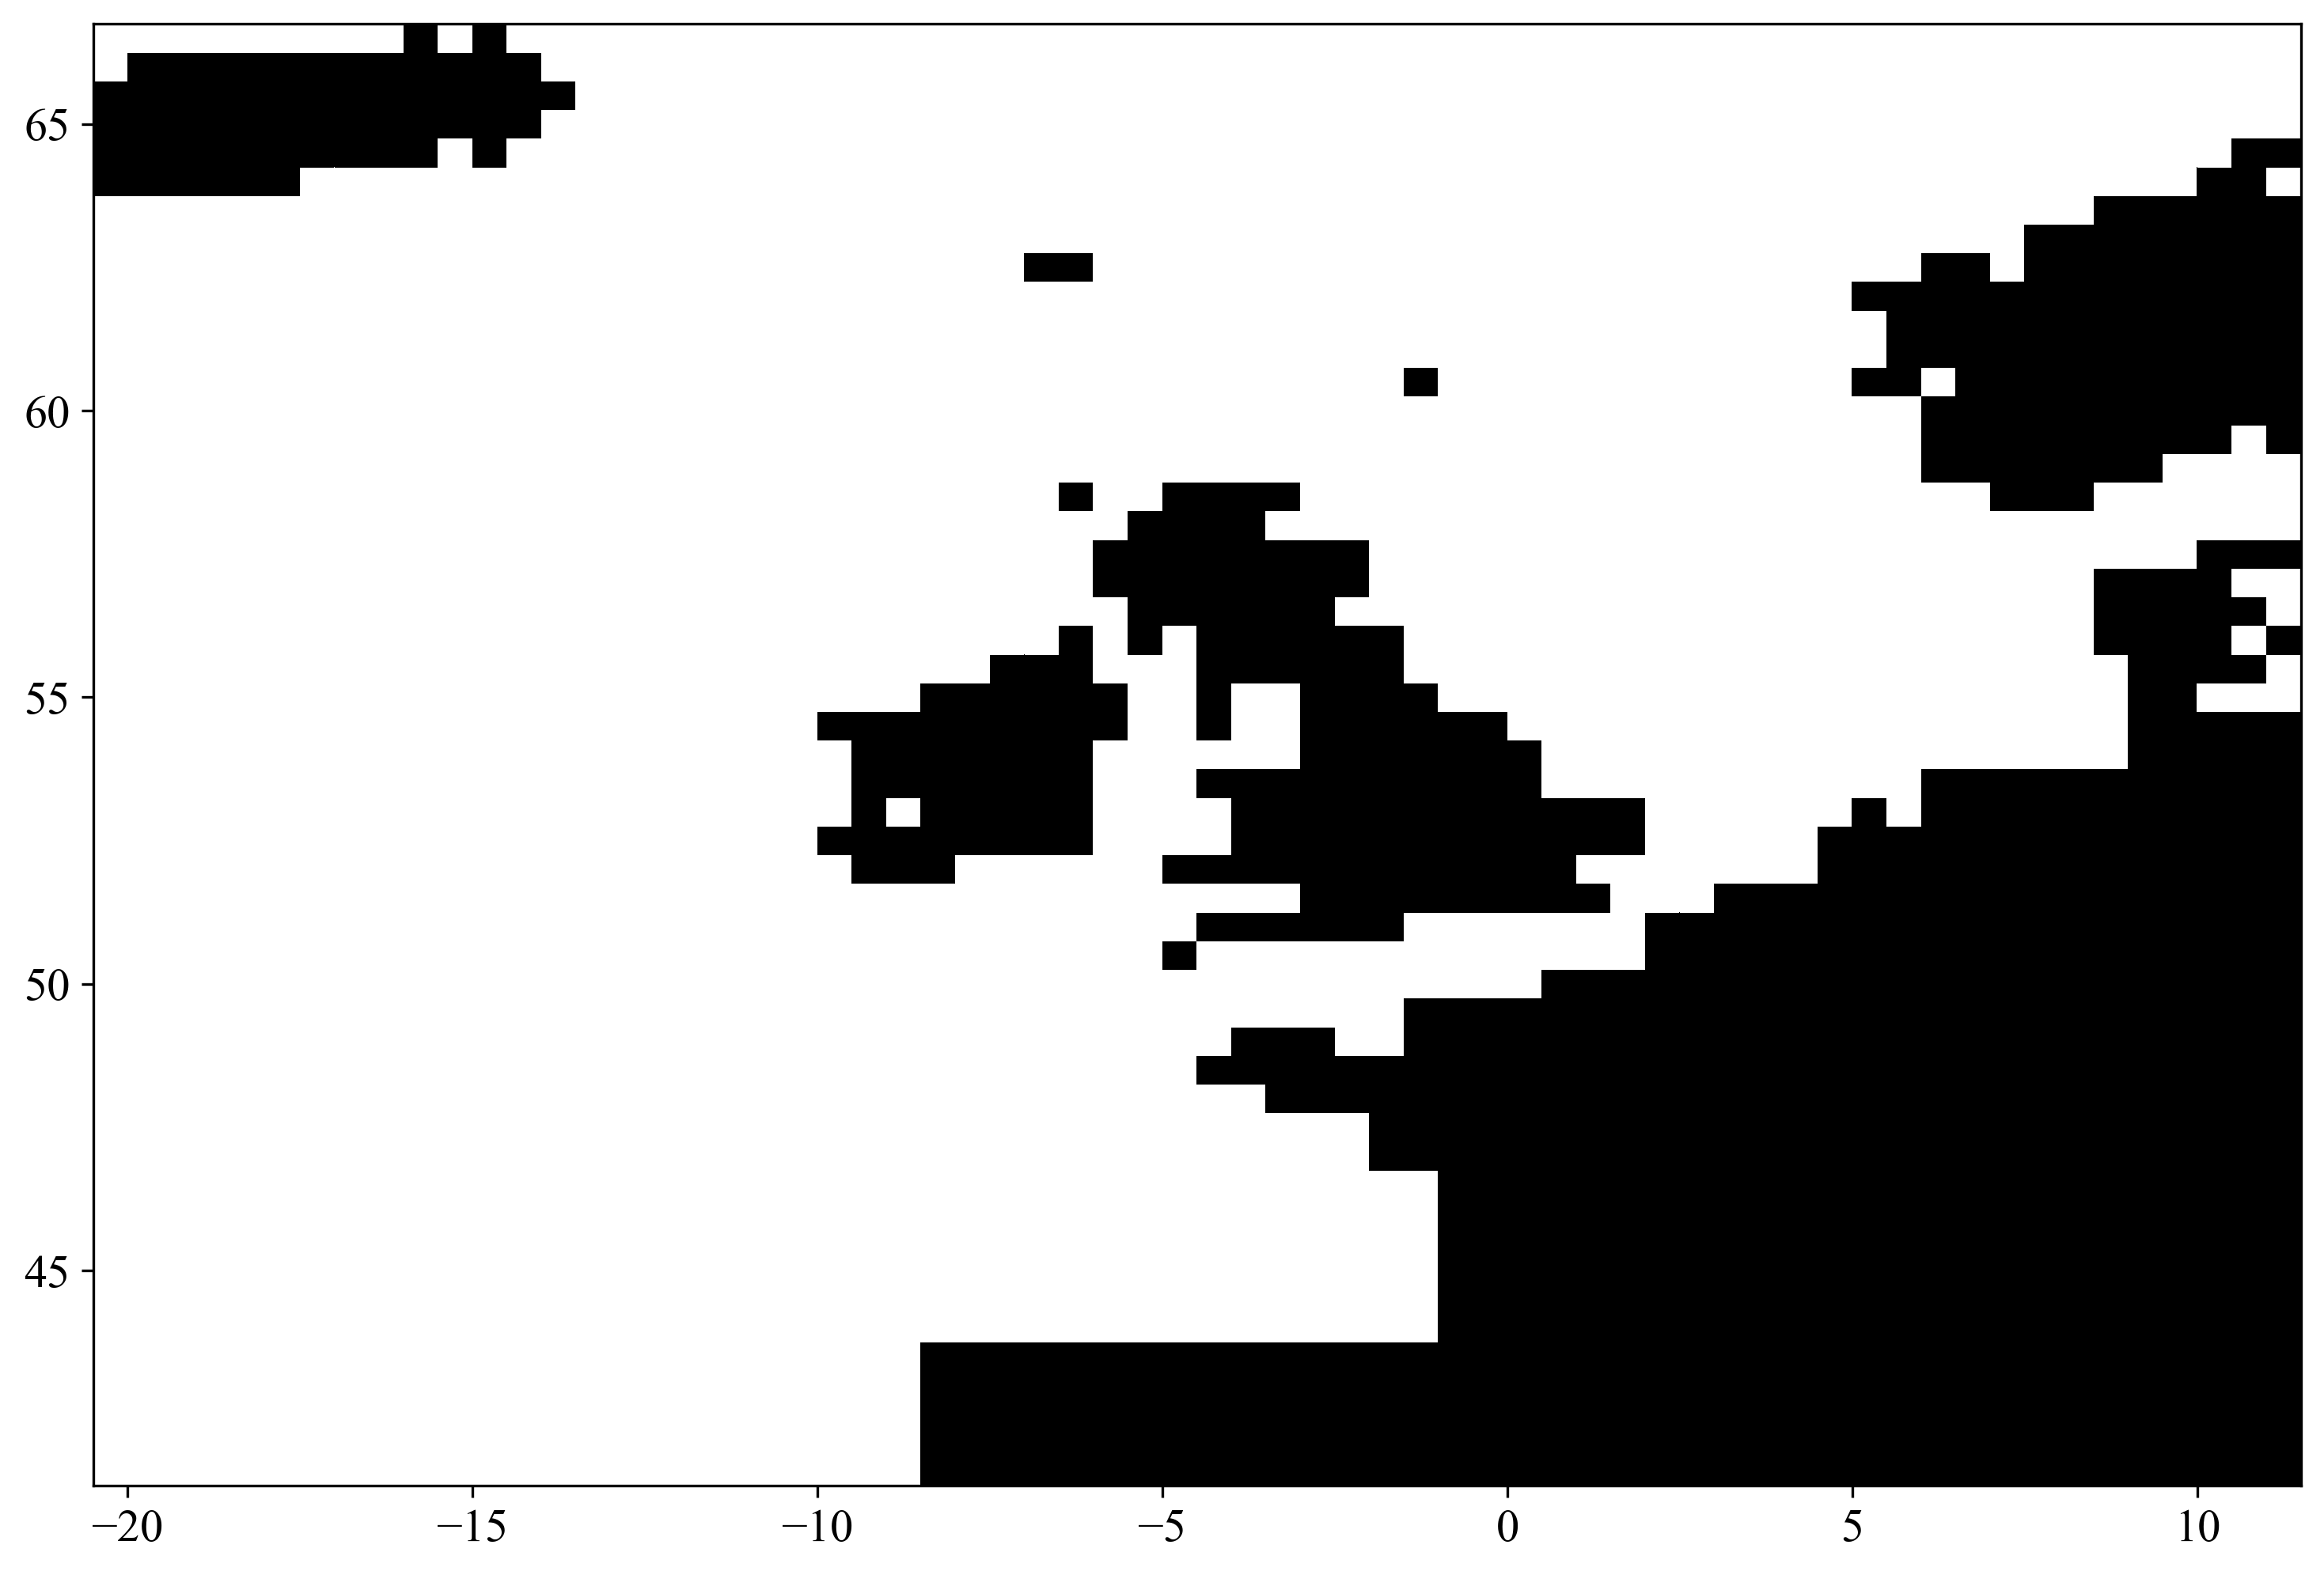

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/ctroupin/.julia/packages/PyCall/3fwVL/src/numpy.jl:67


In [8]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r)
plt.show()

## Read the data
We will prepare monthly fields for given time periods.

In [9]:
yearmin = 2001
yearmax = 2001
imonth = 4

4

### Temperature

In [10]:
@time obsvalue, obslon, obslat, obsdepth, obstime, obsids = loadobs(Float64, temperaturefile, "Temperature");
year_temperature = Dates.year.(obstime);
month_temperature = Dates.month.(obstime);
goodyear = (year_temperature .>= yearmin ) .& (year_temperature .<= yearmax) .& (month_temperature .== imonth)
@info("Found $(sum(goodyear)) observations for the period $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)");

  1.295216 seconds (4.18 M allocations: 282.981 MiB, 7.65% gc time, 85.31% compilation time)


┌ Info: Found 1015 observations for the period April 2001 - 2001
└ @ Main In[10]:5


In [11]:
@time lonT, latT, depthT, timeT, dataT = obslon[goodyear], obslat[goodyear], obsdepth[goodyear], 
obstime[goodyear], obsvalue[goodyear];

  0.090387 seconds (123.09 k allocations: 6.343 MiB, 99.75% compilation time)


In [47]:
Tmin = 5.
Tmax = 15.

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
pcm = ax.scatter(lonT, latT, s=7, c=dataT, cmap=plt.cm.RdYlBu_r, zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
cb = plt.colorbar(pcm)
cb.set_label("T(°C)", rotation=0, ha="left")
ax.set_title("Temperature observations for $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)")
plt.show()

LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/ctroupin/.julia/packages/PyCall/3fwVL/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('cannot reshape array of size 6760 into shape (1,2)')
  File "/home/ctroupin/.julia/conda/3/lib/python3.7/site-packages/matplotlib/__init__.py", line 1599, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/home/ctroupin/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 6165, in pcolormesh
    X, Y, C = self._pcolorargs('pcolormesh', *args, allmatch=allmatch)
  File "/home/ctroupin/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 5742, in _pcolorargs
    x = X.reshape(1, Nx)


### Plankton

In [13]:
data = DelimitedFiles.readdlm(datafile, ',', skipstart=1);
lonCPR = Float64.(data[:,3])
latCPR = Float64.(data[:,2])
yearCPR = data[:,4]
monthCPR = data[:,5]
timeCPR = Dates.Date.(yearCPR, monthCPR, 15)
calanus_finmarchicus = Float64.(data[:,6])
calanus_helgolandicus = Float64.(data[:,7]);

#### Subsetting

In [14]:
goodyearCPR = (yearCPR .>= yearmin ) .& (yearCPR .<= yearmax) .& (monthCPR .== imonth)
@info("Found plankton $(sum(goodyearCPR)) observations for the period $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)");

┌ Info: Found plankton 261 observations for the period April 2001 - 2001
└ @ Main In[14]:2


In [15]:
@time lon_calanus, lat_calanus, time_calanus, 
calanus_finmarchicus_sel, calanus_helgolandicus_sel = 
lonCPR[goodyearCPR], latCPR[goodyearCPR], timeCPR[goodyearCPR], 
calanus_finmarchicus[goodyearCPR], calanus_helgolandicus[goodyearCPR];

  0.052898 seconds (65.61 k allocations: 3.396 MiB, 99.83% compilation time)


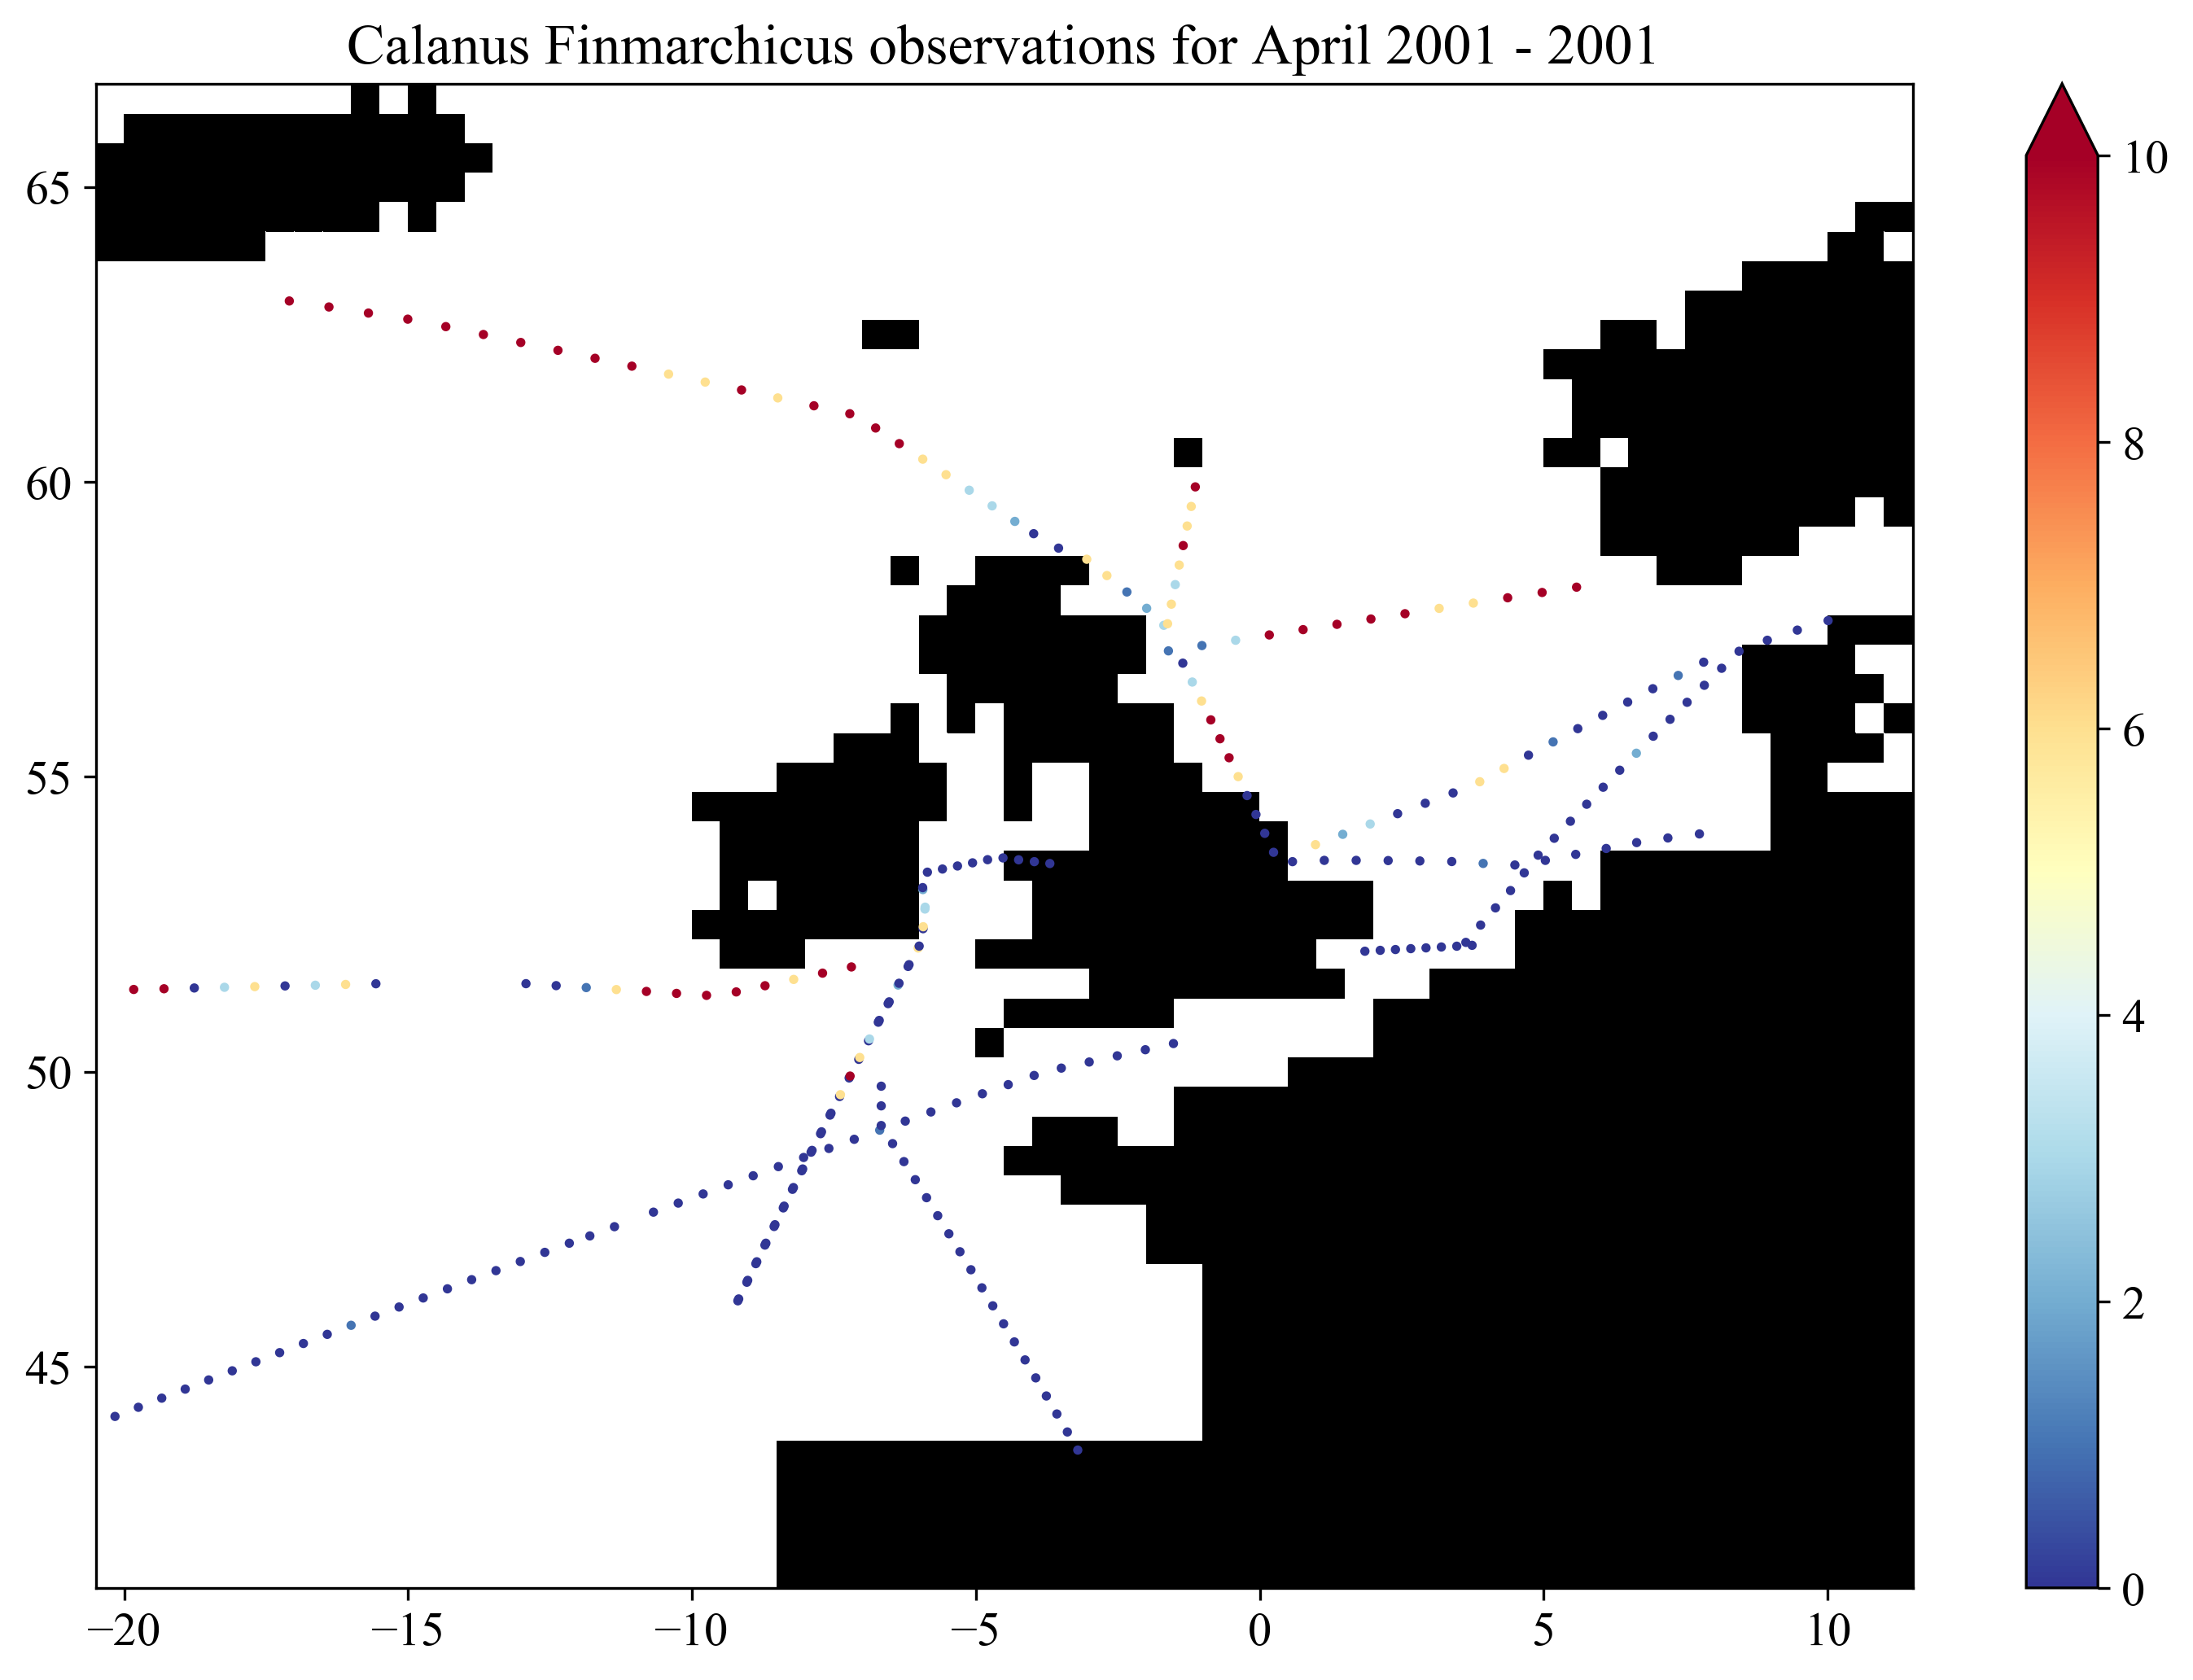

In [16]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
pcm = ax.scatter(lon_calanus, lat_calanus, s=3, c=calanus_finmarchicus_sel, cmap=plt.cm.RdYlBu_r, 
    vmin=0, vmax=10., zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
cb = plt.colorbar(pcm, extend="max")
ax.set_title("Calanus Finmarchicus observations for $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)")
plt.show()

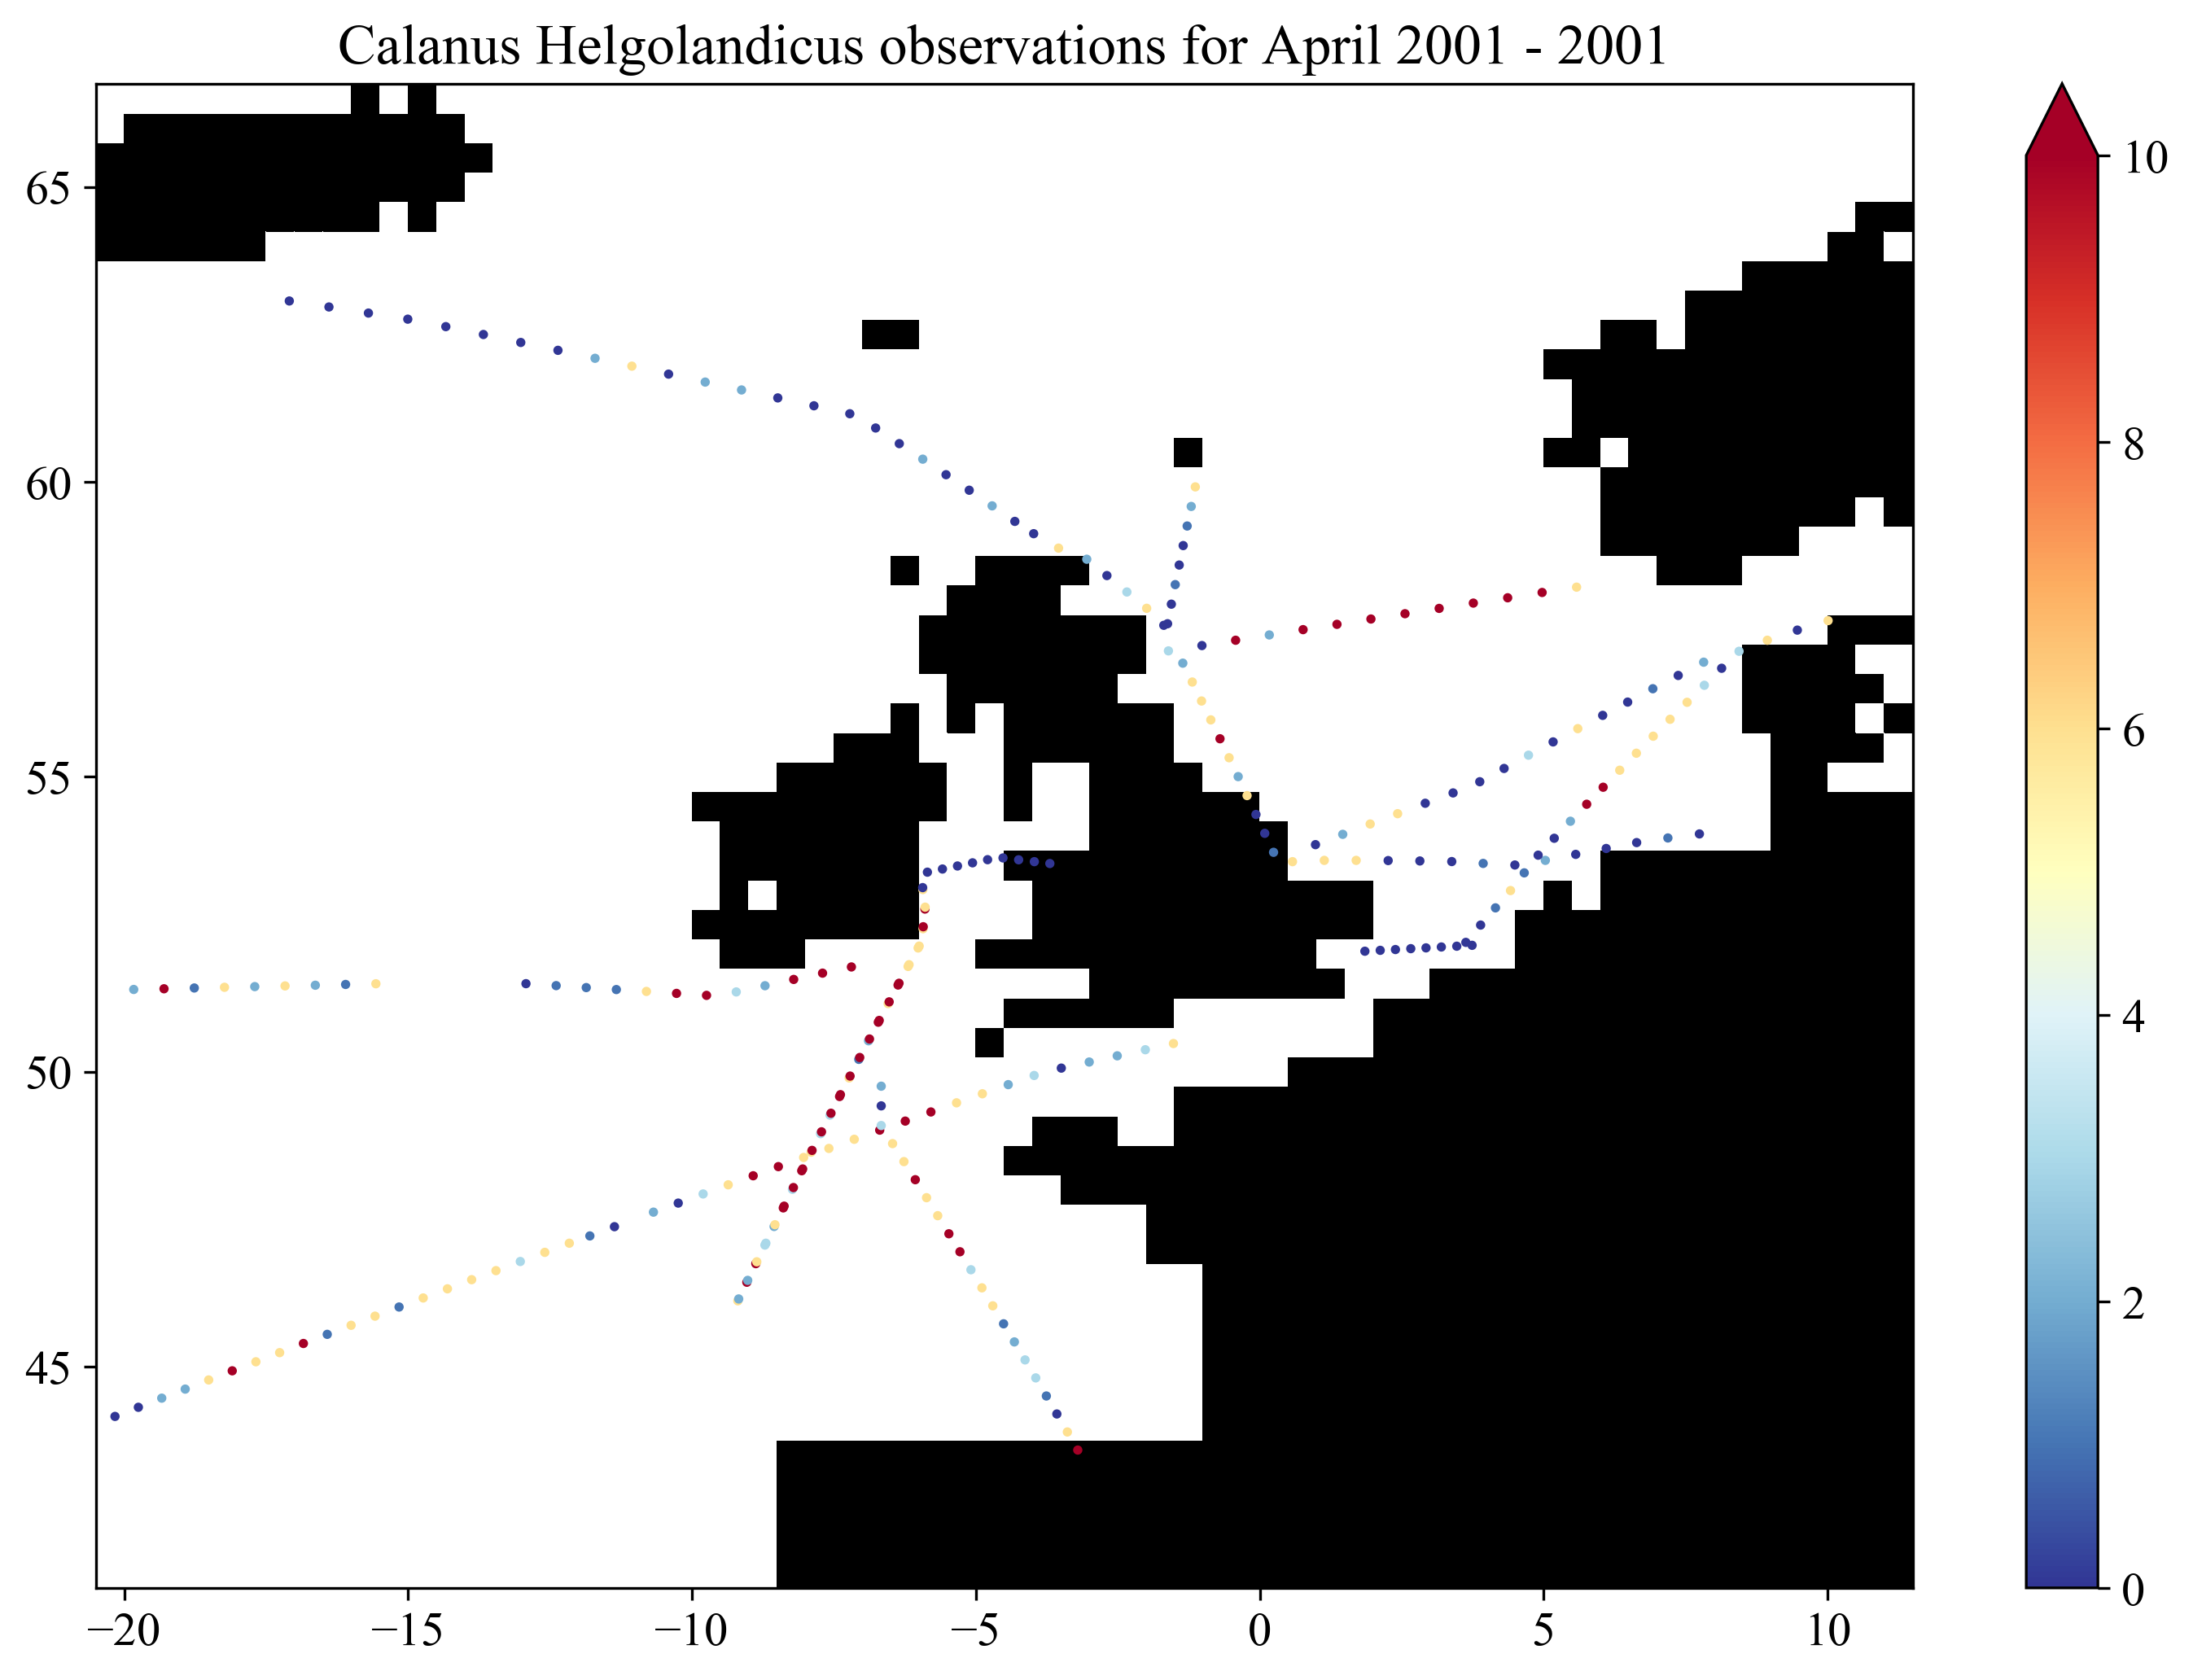

In [17]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
pcm = ax.scatter(lon_calanus, lat_calanus, s=3, c=calanus_helgolandicus_sel, cmap=plt.cm.RdYlBu_r, 
    vmin=0, vmax=10., zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
cb = plt.colorbar(pcm, extend="max")
ax.set_title("Calanus Helgolandicus observations for $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)")
plt.show()

## Univariate analysis
### Parameters

In [18]:
L = 2.5
epsilon2 = 5.

5.0

### Monovariate

In [19]:
@time f_finmarchicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon_calanus, lat_calanus), 
    calanus_finmarchicus_sel .- 0. * mean(calanus_finmarchicus), (L, L), epsilon2);
@time f_helgolandicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon_calanus, lat_calanus), 
    calanus_helgolandicus_sel .- 0. * mean(calanus_helgolandicus_sel), (L, L), epsilon2);

 18.147369 seconds (47.33 M allocations: 2.527 GiB, 5.87% gc time, 99.83% compilation time)
  0.086318 seconds (27.52 k allocations: 30.878 MiB, 32.71% gc time, 47.31% compilation time)


In [20]:
@time T_interp, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lonT, latT), 
    dataT .- 1. * mean(dataT), (L, L), epsilon2);

  0.018850 seconds (2.88 k allocations: 30.171 MiB)


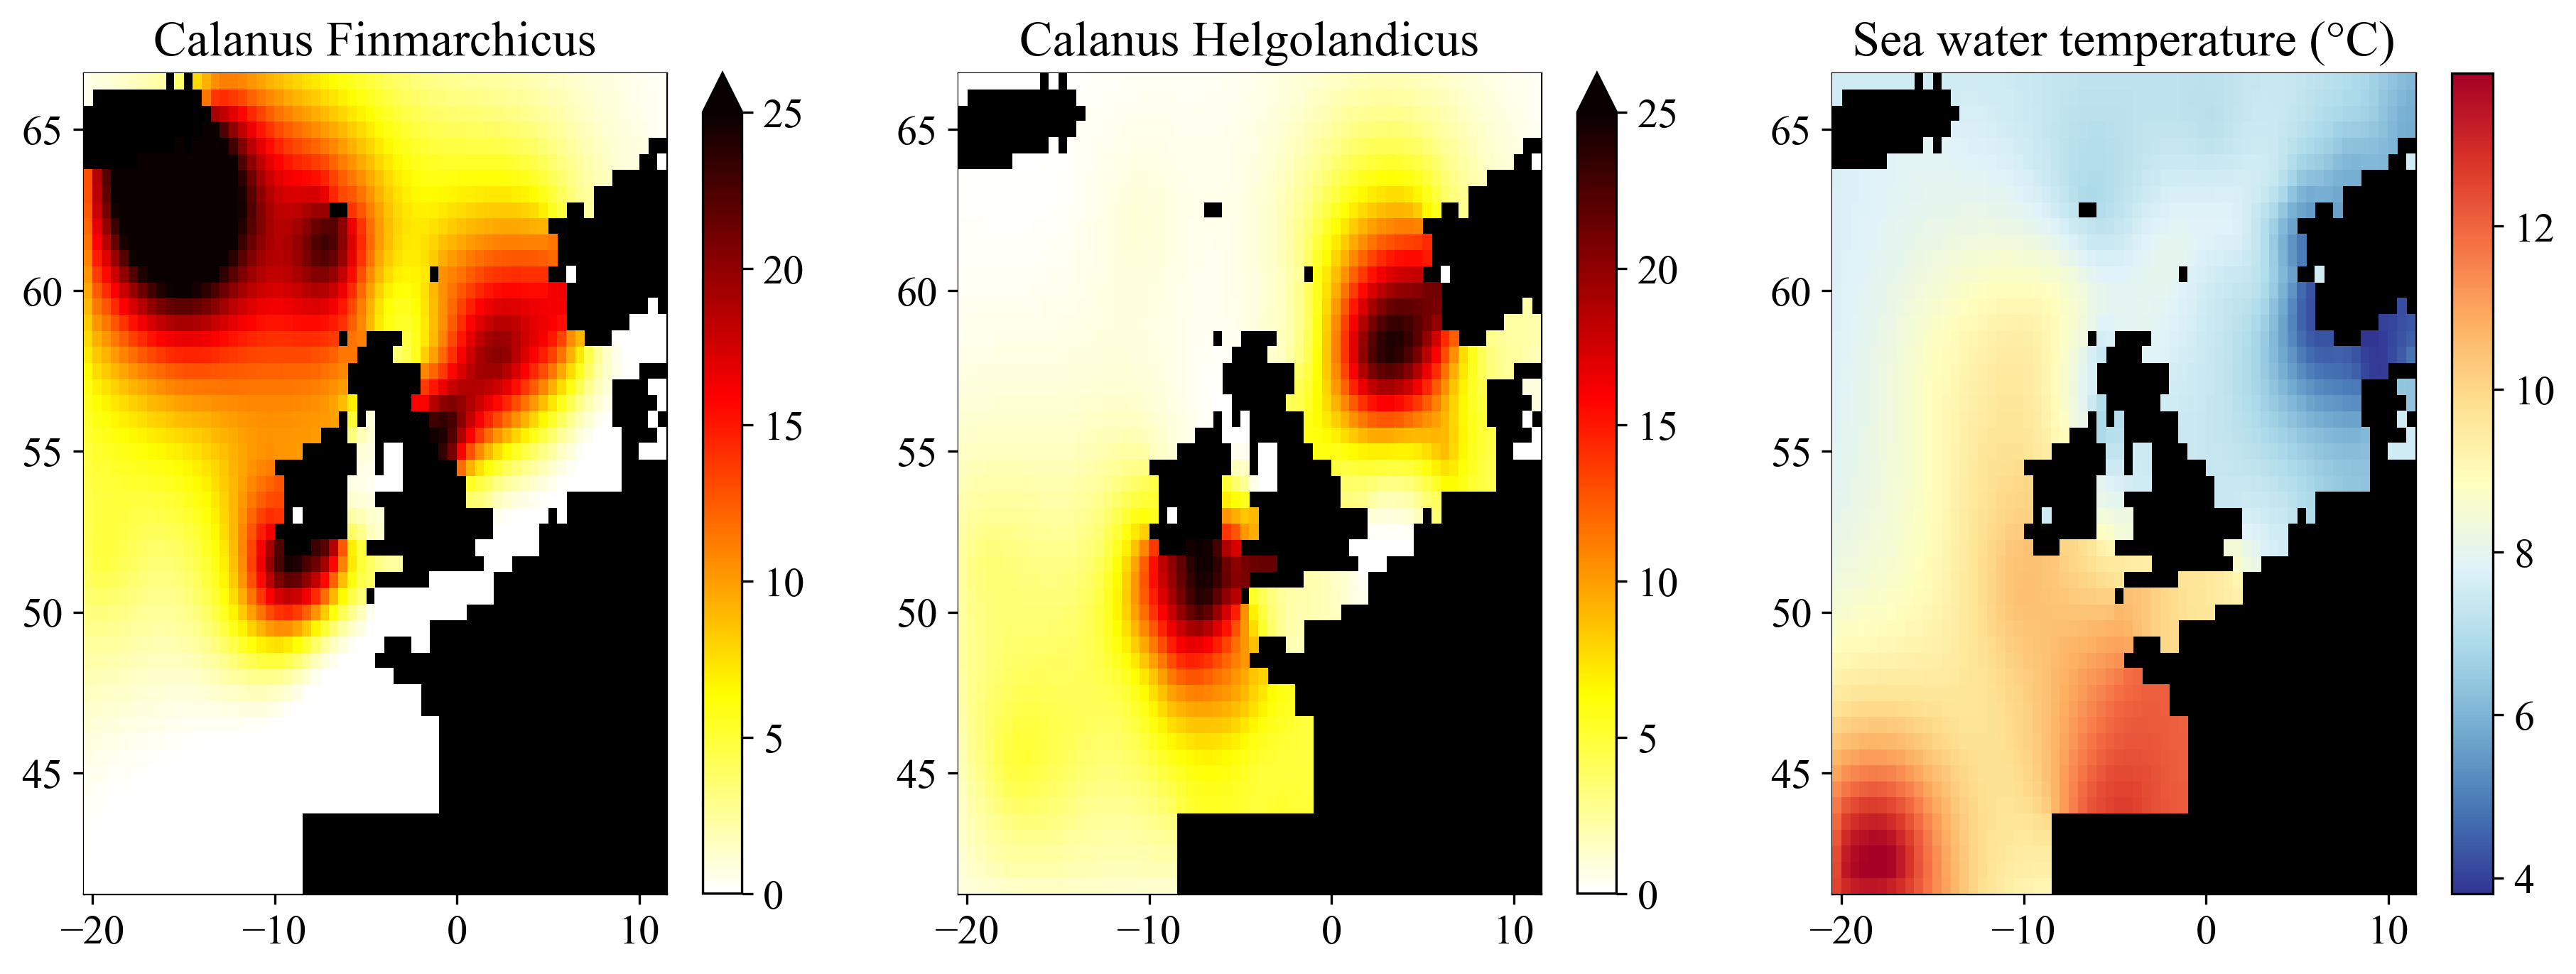

In [21]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi, yi, f_finmarchicus, vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi, yi, f_helgolandicus, vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)

ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi, yi, T_interp .+ mean(dataT), cmap=plt.cm.RdYlBu_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)

ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)


plt.show()

## Multivariate analysis
### Data preparation
1. Concatenate all the coordinate and observation vectors
2. Normalise the variables
3. Create a new dimension `vvv` with value **1** for plankton data points and **2** for temperature observations.

### Create metrics and mask

In [24]:
maskmulti, (pm, pn, pv), (xi, yi, vi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid, 1:2);

In [25]:
maskmulti[:,:,1] = mask;
maskmulti[:,:,2] = mask;

### Perform analysis

In [26]:
@time fi1,s = DIVAndrun(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
    (L, L, 0.0), epsilon2);

@time fi2,s = DIVAndrun(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
    (L, L, 0.0), epsilon2);

  8.122569 seconds (19.45 M allocations: 1.041 GiB, 4.61% gc time, 99.28% compilation time)
  0.036808 seconds (4.01 k allocations: 73.521 MiB)


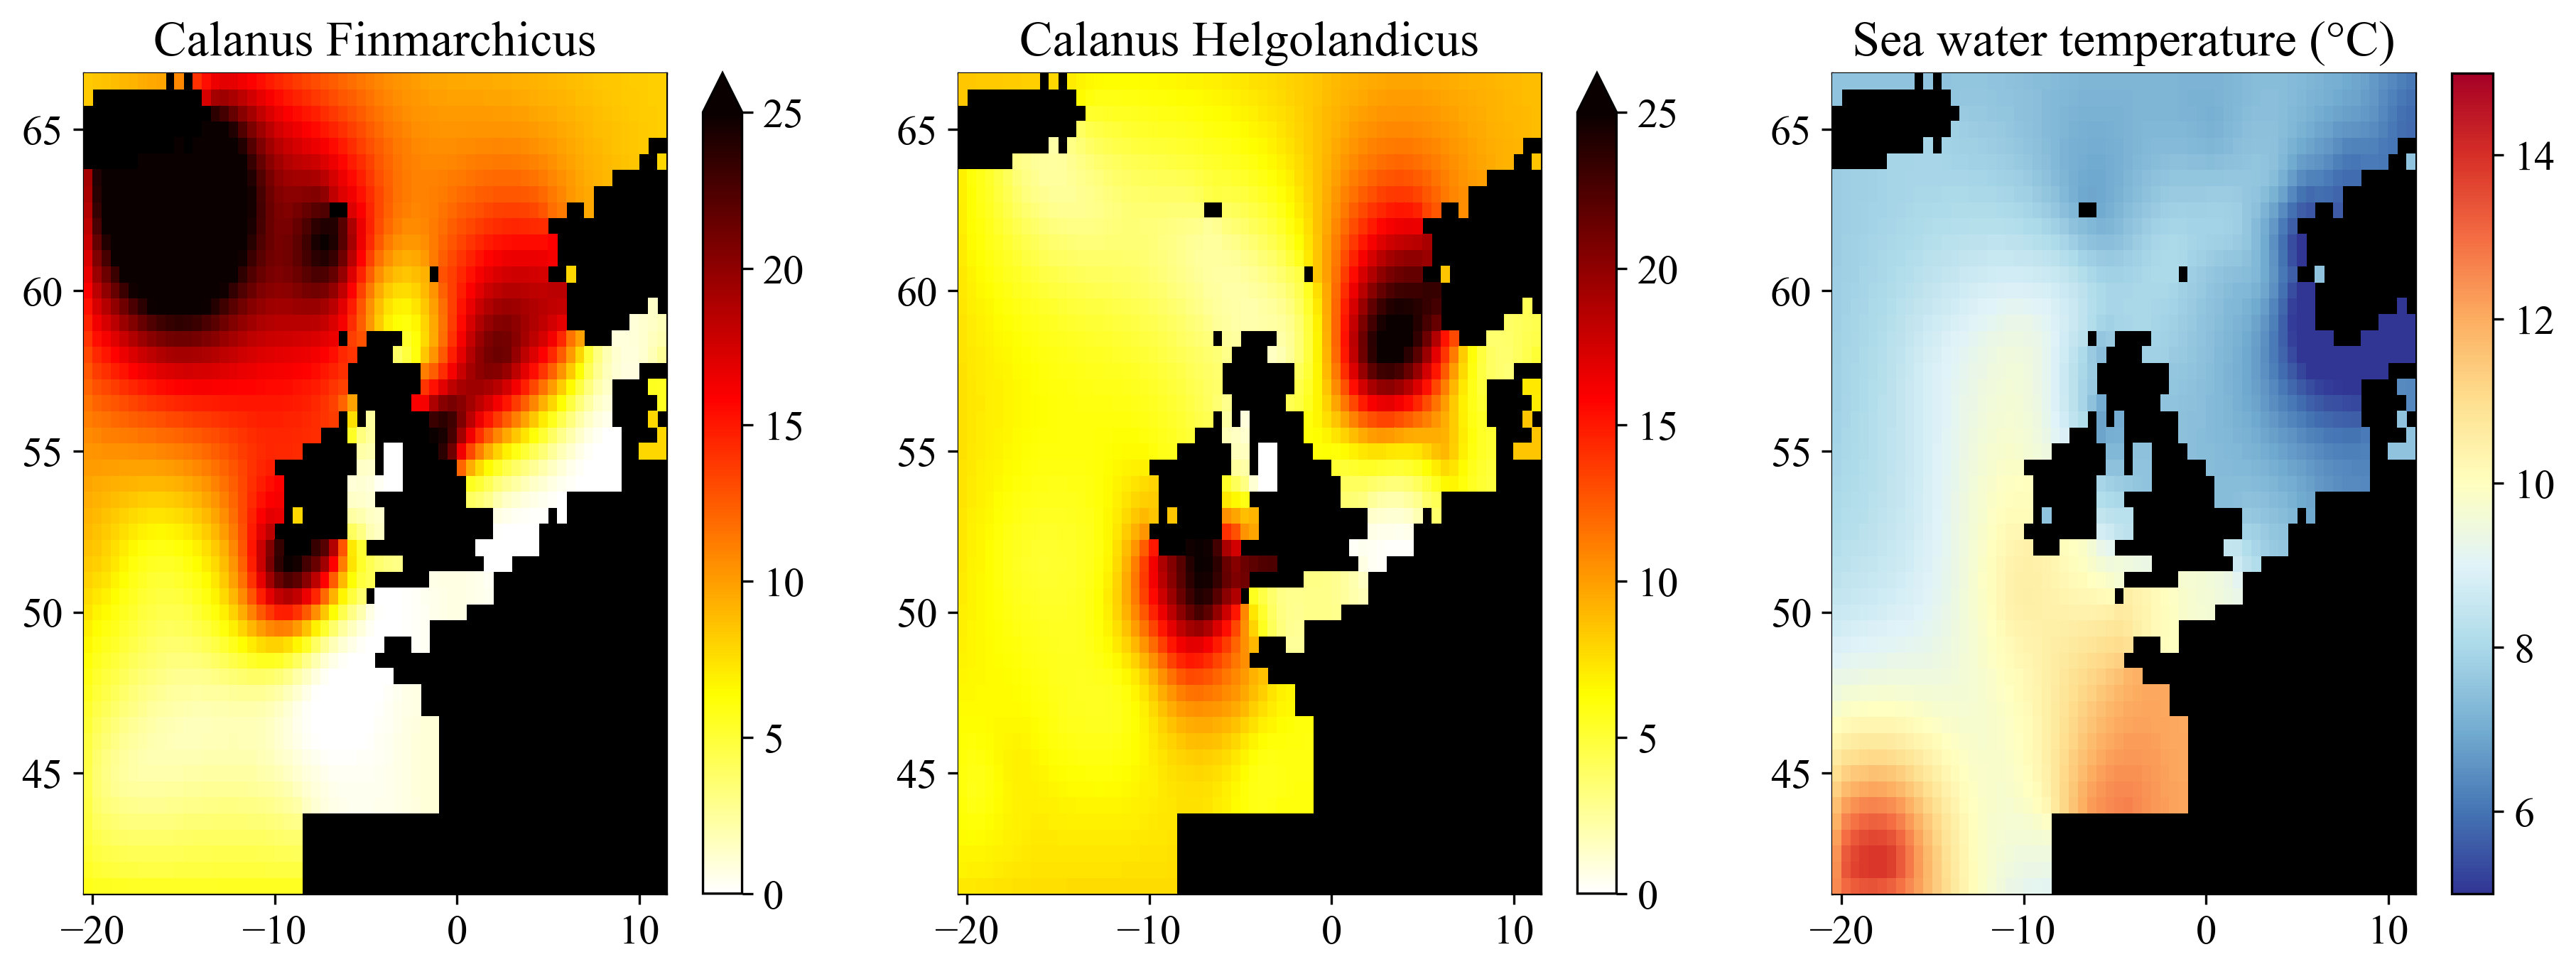

In [53]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fi1[:,:,1] .* calanus_finmarchicus_sel_std) .+ calanus_finmarchicus_sel_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fi2[:,:,1] .* calanus_helgolandicus_sel_std) .+ calanus_helgolandicus_sel_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1],
    (fi1[:,:,2] .* dataT_std) .+ mean(dataT), 
    cmap=plt.cm.RdYlBu_r, zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)

plt.savefig(joinpath(figdir, "monovariate01.png"), dpi=300, bbox_inches="tight")
plt.show()

### Some tests if we get it right
The 1st _component_ of the multivariate gridded fields should be the same as those obtained with the univariate analysis.         
The 2nd _component_ should be the temperature analysis.

In [28]:
using Test

In [29]:
@test fi1[mask,1] == f_finmarchicus[mask]
@test fi2[mask,1] == f_helgolandicus[mask]
@test fi1[mask,2] == fi2[mask,2]
@test fi1[mask,2] == T_interp[mask]

Test Failed at In[29]:1
  Expression: fi1[mask, 1] == f_finmarchicus[mask]
   Evaluated: [-0.09478458944882077, -0.10055279400076908, -0.10364850673568687, -0.10642111704487568, -0.10872302276314073, -0.11047773988549206, -0.1116718561186987, -0.11234089606810832, -0.11255385205642385, -0.112399127087624  …  0.024904581965426047, 0.022341305761471815, 0.019896403552202988, 0.017591265295019903, 0.015439553811643913, 0.013448298425413834, 0.011619931851697112, 0.009954664099439908, 0.008451588683582112, 0.00603221897507857] == [-0.007540475772095091, -0.038936605771435484, -0.05745902300368352, -0.0766614646032799, -0.09626067540131146, -0.11609700500749215, -0.13611622421466965, -0.15633711110916831, -0.1768137636787002, -0.19759940228772316  …  0.8038538906453334, 0.7182220198580633, 0.6373212573258602, 0.5616597194162768, 0.49151715214406577, 0.4269812743359095, 0.36801214168547064, 0.31451607758803807, 0.2663791489870303, 0.18906717452935165]


LoadError: [91mThere was an error during testing[39m

## Multivariate analysis
### EOF approach

In [43]:
@time fim1, s1, eof1, eofamplitudes1, emap1, emapm1 = 
DIVAnd_multivarEOF(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
    (L, L, 0.0 .*L), epsilon2);

  0.319193 seconds (54.40 k allocations: 538.599 MiB, 4.44% gc time)


In [44]:
size(emap1), size(emapm1)

((65, 52, 2), (65, 52, 2))

In [45]:
@time fim2, s2, eof2, eofamplitudes2, emap2, emapm2 = 
DIVAnd_multivarEOF(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
    (L, L, 0.0 .*L), epsilon2);

  0.078645 seconds (8.23 k allocations: 147.940 MiB, 4.39% gc time)


┌ Warning: Sorry too weak  correlations layer 1
└ @ DIVAnd /home/ctroupin/ULiege/Tools/DIVAnd.jl/src/DIVAnd_multivarEOF.jl:208


#### Plot the gridded fields

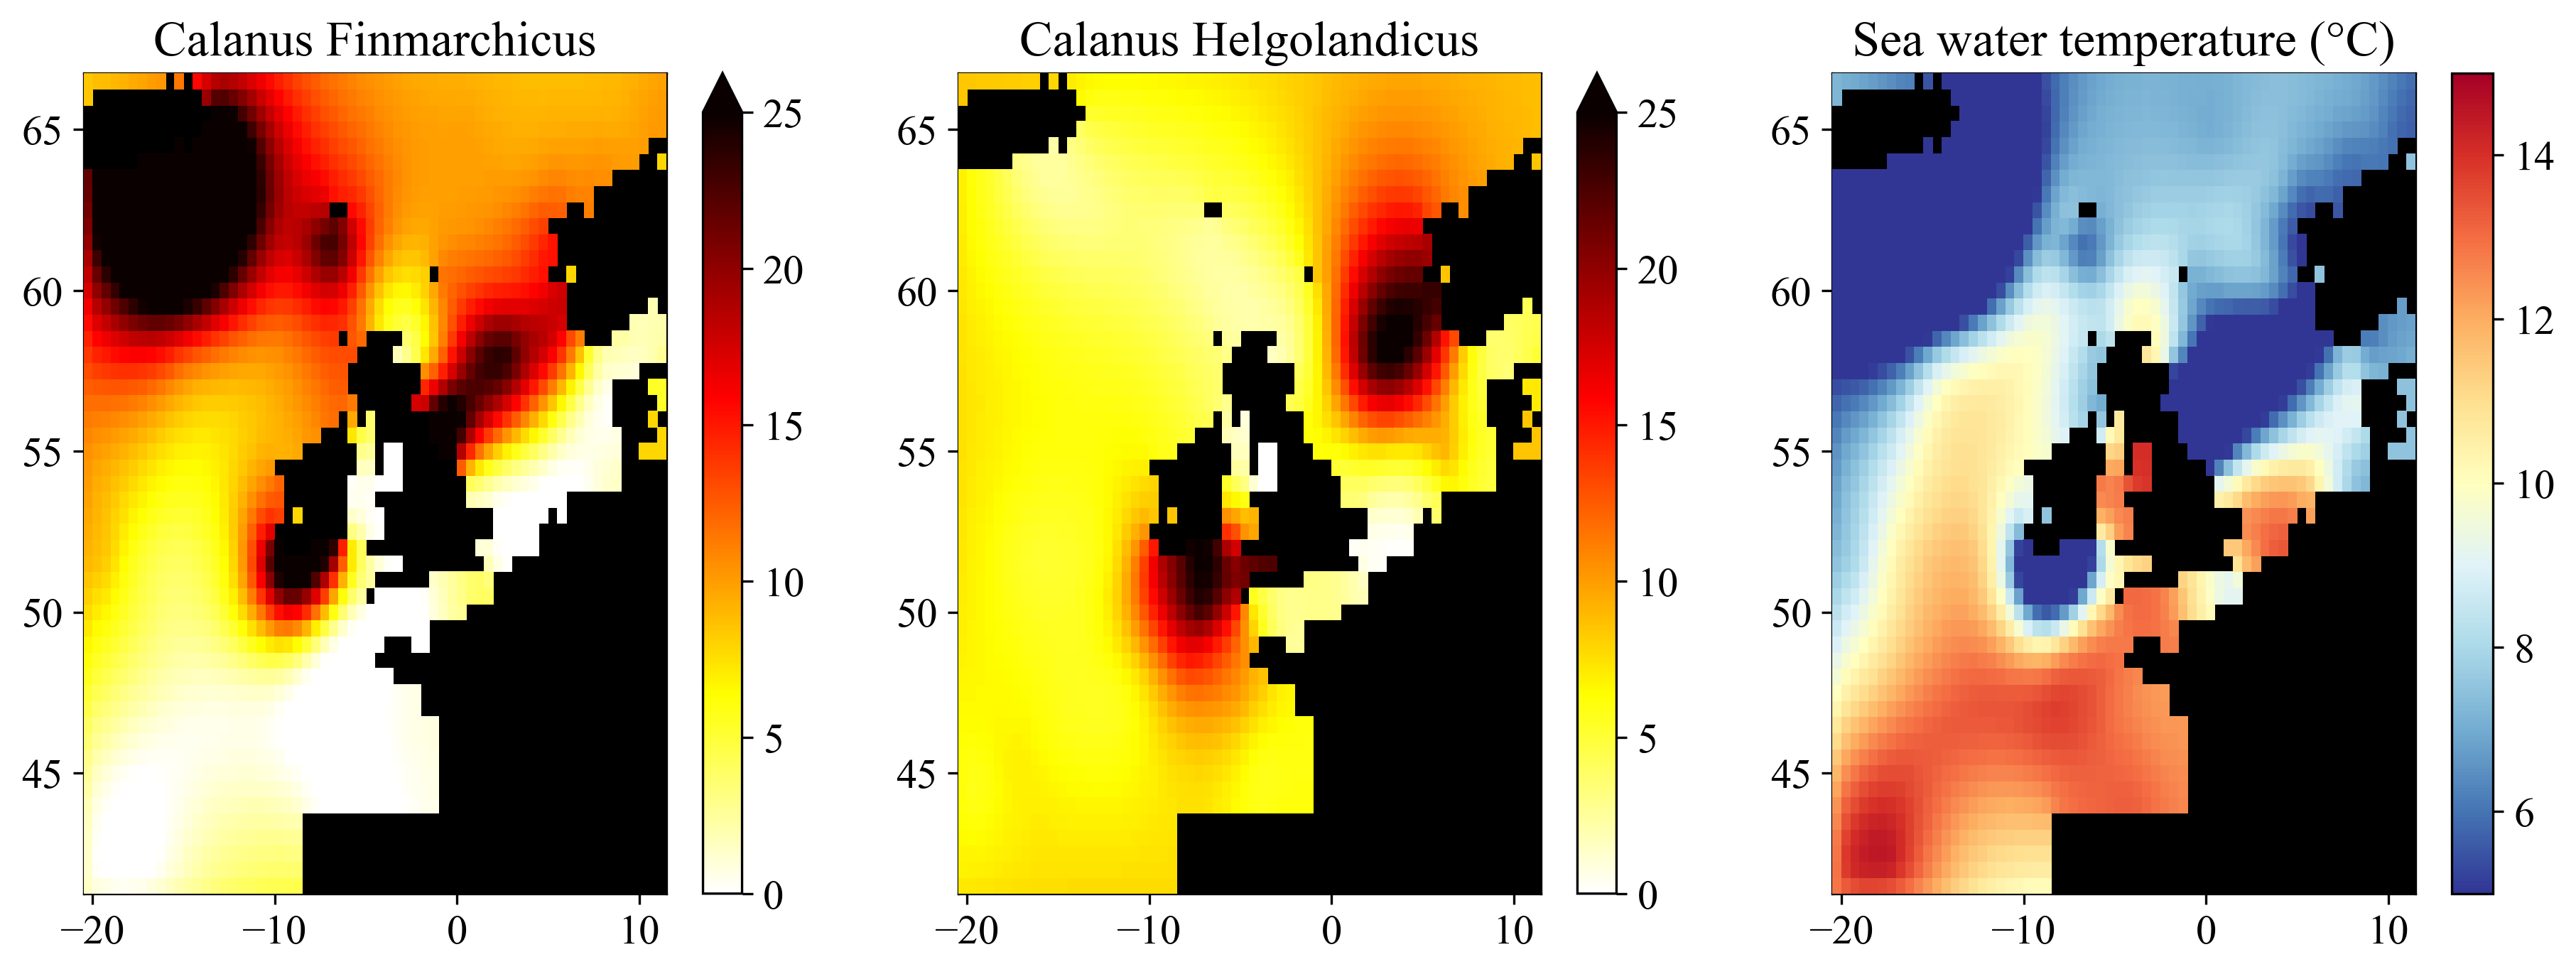

In [52]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim1[:,:,1] .* calanus_finmarchicus_sel_std) .+ calanus_finmarchicus_sel_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim2[:,:,1] .* calanus_helgolandicus_sel_std) .+ calanus_helgolandicus_sel_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], (fim1[:,:,2] .* dataT_std) .+ mean(dataT), cmap=plt.cm.RdYlBu_r, 
    zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)
plt.savefig(joinpath(figdir, "multivariate_eof.png"), dpi=300, bbox_inches="tight")

plt.show()

### Jacobian approach

In [39]:
@time fim1Jac, s1, emap1, emapm1, pv1 = DIVAnd_multivarJAC(maskmulti, 
    (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
    (L, L, 0.0 * L), epsilon2; epsilon2jacobian=(1.0,10.));

eps2jac = (1.0, 10.0)
"error method in multivar $(meth)" = "error method in multivar cpme"
methm = "cpme"
  0.762618 seconds (324.38 k allocations: 724.643 MiB, 23.59% gc time)


In [40]:
@time fim2Jac, s2, emap2, emapm2, pv2 = DIVAnd_multivarJAC(maskmulti, (pm,pn,pv), 
    (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
    (L, L, 0.0 * L), epsilon2; epsilon2jacobian=(1.0,10.));

eps2jac = (1.0, 10.0)
"error method in multivar $(meth)" = "error method in multivar cpme"
methm = "cpme"
  1.019878 seconds (324.39 k allocations: 724.643 MiB, 50.42% gc time)


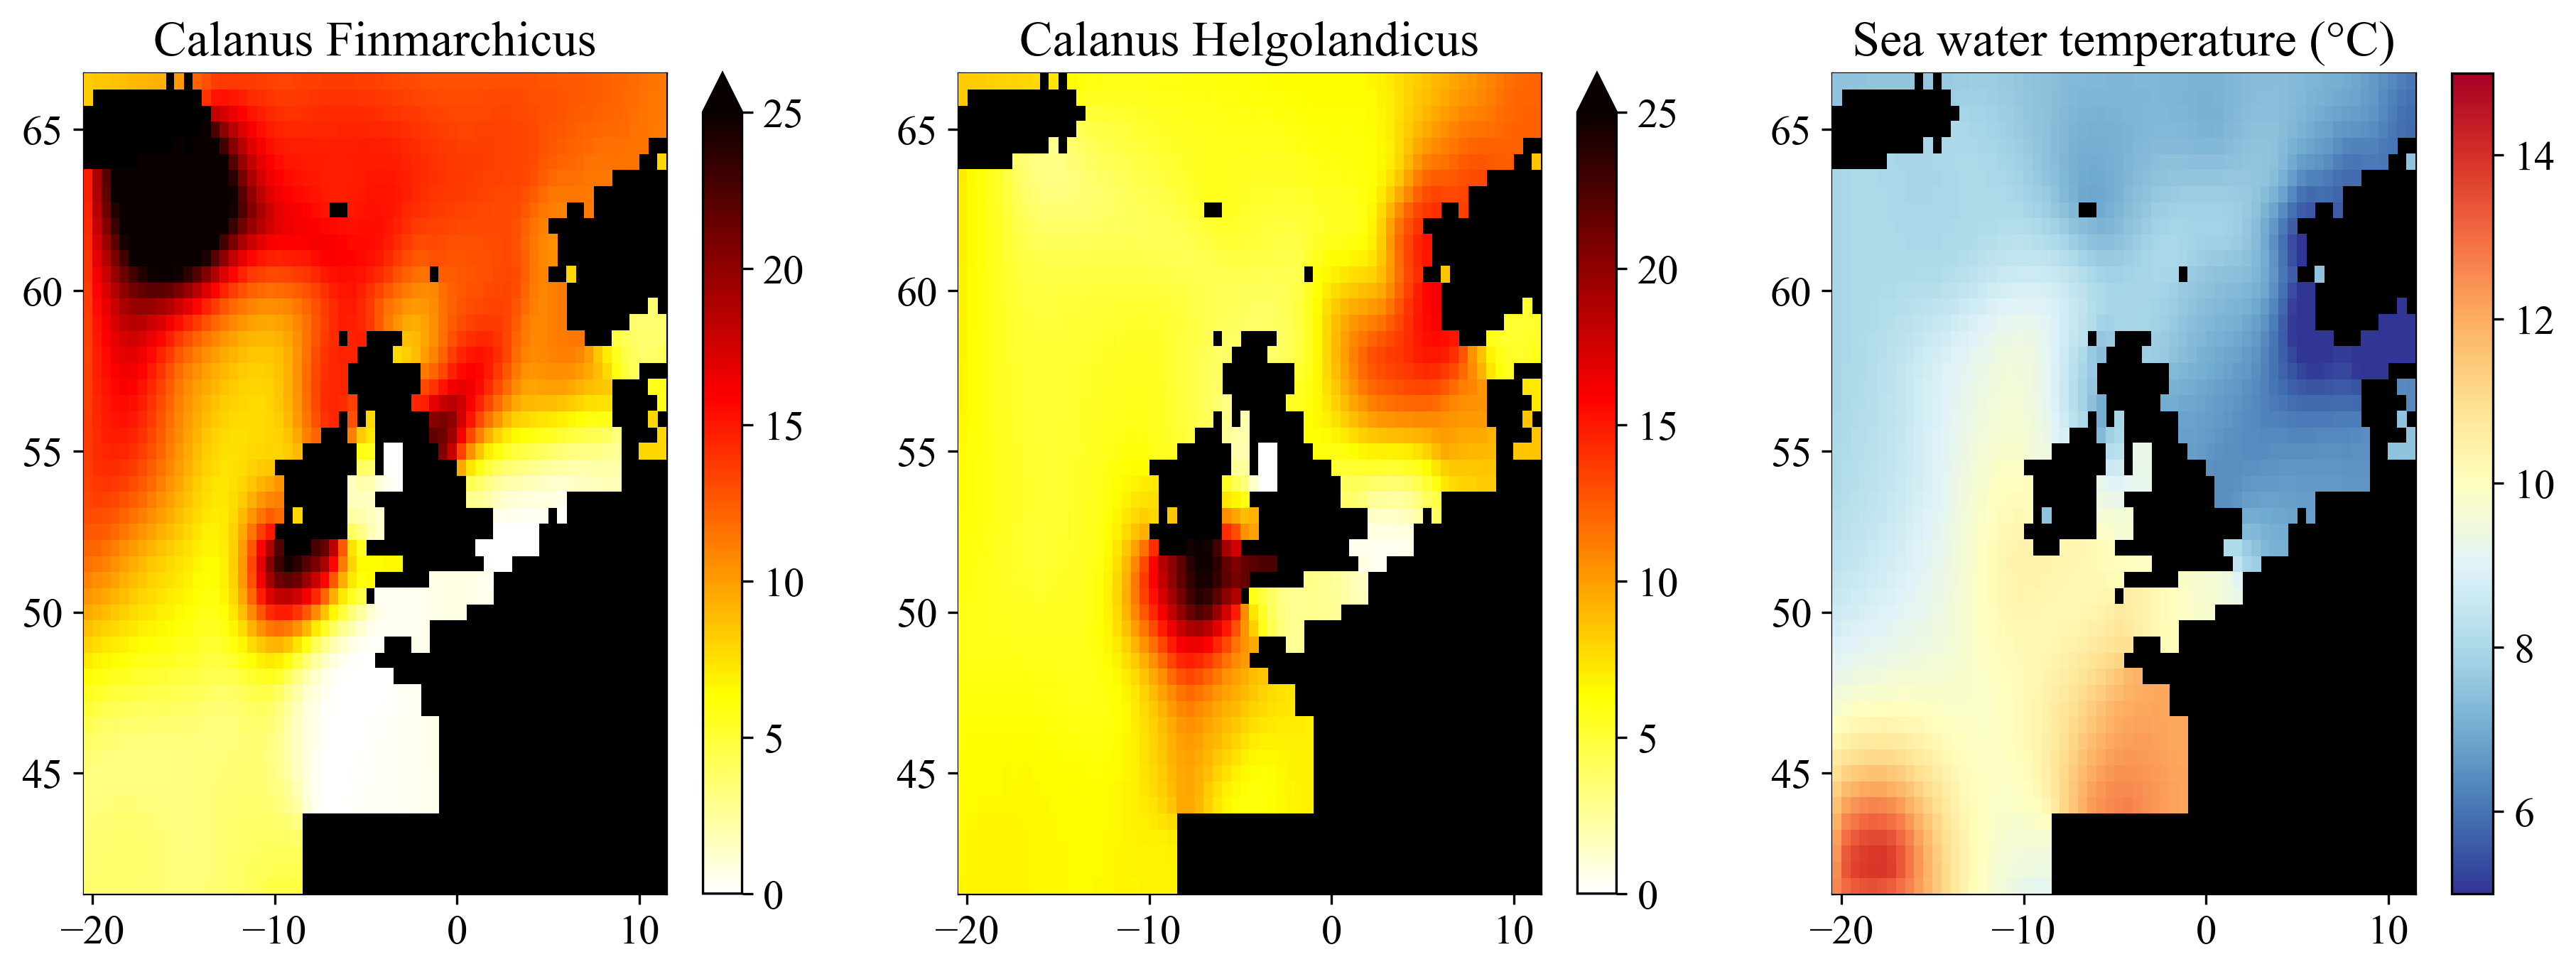

In [51]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim1Jac[:,:,1] .* calanus_finmarchicus_sel_std) .+ calanus_finmarchicus_sel_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim2Jac[:,:,1] .* calanus_helgolandicus_sel_std) .+ calanus_helgolandicus_sel_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], (fim1Jac[:,:,2] .* dataT_std) .+ mean(dataT), 
    cmap=plt.cm.RdYlBu_r, 
    zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)

plt.savefig(joinpath(figdir, "multivariate_jac.png"), dpi=300, bbox_inches="tight")


plt.show()